# About

This notebook is focused on retrieving the XML data via King County's API, cleaning it into Pandas Data Frame format, and formatting the values and data types.

#### Notebook contents<a id="top"></a>

* <a href="#xml">Get the raw XML</a>
* <a href="#parsexml">Element tree structure</a>
* <a href="#toulouse">A business with lots of violations: Toulouse Petit</a>
* <a href="#dataframe">Reformatting XML into a Pandas Data Frame</a>
* <a href="#clean">Data cleaning</a>
* <a href="#plot">Visual inspection</a>

![5 second rule](extras/foodsafety.jpeg)

In [1]:
import requests
import xml.etree.ElementTree as ET
import pandas as pd
import folium
from folium import plugins
from matplotlib import pyplot as plt
plt.style.use('seaborn-white')
import toyplot
%matplotlib inline

## Get the raw XML<a id="xml"></id>
[<a href="#top">back to top</a>]

In [2]:
def get_xml(**kwargs):
    ''' Returns root XML tree structure using King County's API
    
        Kwargs
        ======
        Business_Name - string
        Business_Address - string
        Zip_Code - string
        Inspection_Start - string with valid date in format MM/DD/YYYY
        Inspection_End - string with valid date in format MM/DD/YYYY
        Violation_Points - string with Integer <= 999
        Violation_Red_Points - string with Integer <=999
        City - string
        
        Example
        =======
        Returns inspection data in zip code 98101 since 1/1/2016
        >>> get_data(Zip_Code='98101', Inspection_Start=1/1/2016)
        
        Notes
        =====
        The API appears to break using parameter Inspection_Closed_Business
    '''
    if kwargs == None:
        print('Oh no! You forgot to select at least one parameter')
        return
        
    else:
        url = 'http://info.kingcounty.gov/health/ehs/foodsafety/inspections/XmlRest.aspx?'
        for key in kwargs:
            s = '='.join([key, kwargs[key]])
            url = '&'.join([url, s])
    # retrieve data
    response = requests.get(url)
    root = ET.fromstring(response.content)
    # Remove the King County data disclaimer
    disclaimer_element = root.find('Disclaimer')
    root.remove(disclaimer_element)
    return root

Toulouse Petit is a popular restaurant in Seattle that recently got closed by the health department for failing inspections. Let's pull 2016 inspections which would include the Toulouse Petit violations to verify the structure of the data.

In [3]:
# get some data that would select Toulouse Petit
root = get_xml(Zip_Code='98109', Inspection_Start='1/1/2016', Inspection_End='12/31/2016')

According to King County's API documentation, this is equivalent to pasting
http://info.kingcounty.gov/health/ehs/foodsafety/inspections/XmlRest.aspx?Zip_code=98109&Inspection_Start=1/1/2016&Inspection_End=12/31/2016
in the browser.

## Element tree structure<a id="parsexml"></id>
[<a href="#top">back to top</a>]

Let's see what kind of tags are available to query from the data for each business

In [4]:
list(root[0])

[<Element 'Name' at 0x10dc06810>,
 <Element 'Program_Identifier' at 0x10dc06850>,
 <Element 'Description' at 0x1104be0d0>,
 <Element 'Address' at 0x1104be110>,
 <Element 'City' at 0x1104be450>,
 <Element 'Zip_Code' at 0x1104be190>,
 <Element 'Phone' at 0x1104be3d0>,
 <Element 'Longitude' at 0x1104be410>,
 <Element 'Latitude' at 0x1104be350>,
 <Element 'Inspection' at 0x1104be890>,
 <Element 'Inspection' at 0x1104bedd0>,
 <Element 'Inspection' at 0x11059d110>]

Do any of these elements have children?

In [5]:
for child in list(root[0]):
    print(child.tag, list(child))

('Name', [])
('Program_Identifier', [])
('Description', [])
('Address', [])
('City', [])
('Zip_Code', [])
('Phone', [])
('Longitude', [])
('Latitude', [])
('Inspection', [<Element 'Inspection_Date' at 0x1104be490>, <Element 'Inspection_Business_Name' at 0x1104be910>, <Element 'Inspection_Type' at 0x1104be990>, <Element 'Inspection_Score' at 0x1104be9d0>, <Element 'Inspection_Result' at 0x1104bea10>, <Element 'Inspection_Closed_Business' at 0x1104bea90>, <Element 'Violation' at 0x1104bead0>, <Element 'Violation' at 0x1104bebd0>, <Element 'Violation' at 0x1104becd0>])
('Inspection', [<Element 'Inspection_Date' at 0x1104bee10>, <Element 'Inspection_Business_Name' at 0x1104bee50>, <Element 'Inspection_Type' at 0x1104beed0>, <Element 'Inspection_Score' at 0x1104bef10>, <Element 'Inspection_Result' at 0x1104bef50>, <Element 'Inspection_Closed_Business' at 0x1104bef90>, <Element 'Violation' at 0x1104befd0>])
('Inspection', [<Element 'Inspection_Date' at 0x11059d150>, <Element 'Inspection_Busi

The 'Inspection' element is not terminal. Are any of its elements non-terminal as well?

In [6]:
# the last inspection for the first business in root
list(root[0][-1])

[<Element 'Inspection_Date' at 0x11059d150>,
 <Element 'Inspection_Business_Name' at 0x11059d190>,
 <Element 'Inspection_Type' at 0x11059d210>,
 <Element 'Inspection_Score' at 0x11059d250>,
 <Element 'Inspection_Result' at 0x11059d290>,
 <Element 'Inspection_Closed_Business' at 0x11059d2d0>,
 <Element 'Violation' at 0x11059d310>,
 <Element 'Violation' at 0x11059d410>]

In [7]:
# So the value for the Inspection_Date would be... 
root[0][-1][0].text

'02/24/2016'

In the raw XML (downloaded or viewing in the browser), it looks like each Violation has child elements as well.

In [8]:
# elements for the first business, last inspection, last violation of that inspection
list(root[0][-1][-1])

[<Element 'Violation_Type' at 0x11059d450>,
 <Element 'Violation_Descr' at 0x11059d490>,
 <Element 'Violation_Points' at 0x11059d4d0>]

In [9]:
root[0][-1][-1][1].text # Violation_Descr for above

'4200 - Food-contact surfaces maintained, clean, sanitized'

And then... 

![i hate xml](extras/hatexml.jpg)

... yeah. Something like that.

## A business with lots of violations: Toulouse Petit<a id="toulouse"></id>
[<a href="#top">back to top</a>]

As mentioned above, Toulouse Petite is a popular restaurant in Seattle that was [recently shut down by the Health Department for excessive violations](http://www.seattletimes.com/seattle-news/health/toulouse-petit-kitchen-in-queen-anne-closed-amid-food-poisoning-probe/). Eww. There should be plenty to look at here.

In [16]:
def get_attribute(node, attribute):
    try:
        return node.find(attribute).text
    except:
        return None

In [18]:
def find_business_ix(business_name):
    '''Return index of root for a particular business'''
    for i, biz in enumerate(root):
        if biz.__getitem__(0).text == business_name:
            return i

In [21]:
# Toulouse Petit node
toulouse_petit_ix = find_business_ix('TOULOUSE PETIT KITCHEN & LOUNGE')
business = root[toulouse_petit_ix]

In [22]:
for inspection in business.findall('Inspection'):
        for violation in inspection.findall('Violation'):
            print(get_attribute(business, 'Name'), 
                  get_attribute(inspection, 'Inspection_Date'), 
                  get_attribute(violation, 'Violation_Type'))

('TOULOUSE PETIT KITCHEN & LOUNGE', '10/07/2016', None)
('TOULOUSE PETIT KITCHEN & LOUNGE', '09/27/2016', None)
('TOULOUSE PETIT KITCHEN & LOUNGE', '09/22/2016', 'RED')
('TOULOUSE PETIT KITCHEN & LOUNGE', '09/22/2016', 'RED')
('TOULOUSE PETIT KITCHEN & LOUNGE', '09/22/2016', 'RED')
('TOULOUSE PETIT KITCHEN & LOUNGE', '09/22/2016', 'RED')
('TOULOUSE PETIT KITCHEN & LOUNGE', '09/22/2016', 'RED')
('TOULOUSE PETIT KITCHEN & LOUNGE', '09/22/2016', 'BLUE')
('TOULOUSE PETIT KITCHEN & LOUNGE', '09/22/2016', 'BLUE')
('TOULOUSE PETIT KITCHEN & LOUNGE', '09/22/2016', 'BLUE')
('TOULOUSE PETIT KITCHEN & LOUNGE', '06/20/2016', None)
('TOULOUSE PETIT KITCHEN & LOUNGE', '01/26/2016', 'RED')
('TOULOUSE PETIT KITCHEN & LOUNGE', '01/26/2016', 'BLUE')
('TOULOUSE PETIT KITCHEN & LOUNGE', '01/26/2016', 'BLUE')


Comparing with the raw XML, it looks like all the inspections and violations are being retrieved correctly for Toulouse Petit. 

Now for multiple businesses...

## Reformatting the XML into a Pandas Data Frame<a id="dataframe"></id>
[<a href="#top">back to top</a>]

Finally time to get rid of this unsavory XML format once and for all!

Let's try the above for multiple businesses...

In [23]:
get_attribute(business, 'Name')

'TOULOUSE PETIT KITCHEN & LOUNGE'

In [28]:
businesses = root[0:5]

for b in range(0, len(businesses)):
    business = businesses[b]
    try:
        for inspection in business.findall('Inspection'):
            try: # not every inspection has violations...
                for violation in inspection.findall('Violation'):
                    print(get_attribute(business, 'Name'), 
                          get_attribute(inspection, 'Inspection_Date'), 
                          get_attribute(violation, 'Violation_Type'))
            except:
                print(get_attribute(business, 'Name'), 
                      get_attribute(inspection, 'Inspection_Date'))
    except:
        pass

('10 MERCER RESTAURANT', '10/10/2016', 'RED')
('10 MERCER RESTAURANT', '10/10/2016', 'RED')
('10 MERCER RESTAURANT', '10/10/2016', 'BLUE')
('10 MERCER RESTAURANT', '07/07/2016', None)
('10 MERCER RESTAURANT', '02/24/2016', 'RED')
('10 MERCER RESTAURANT', '02/24/2016', 'BLUE')
('100 LB CLAM', '08/31/2016', None)
('13 COINS', '09/19/2016', 'RED')
('13 COINS', '09/19/2016', 'BLUE')
('13 COINS', '06/01/2016', 'BLUE')
('13 COINS', '05/18/2016', 'RED')
('13 COINS', '05/18/2016', 'RED')
('13 COINS', '05/18/2016', 'RED')
('13 COINS', '05/18/2016', 'BLUE')
('13 COINS', '01/12/2016', 'BLUE')
('5-SPOT', '12/06/2016', 'RED')
('5-SPOT', '12/06/2016', 'BLUE')
('5-SPOT', '07/29/2016', 'RED')
('5-SPOT', '07/29/2016', 'BLUE')
('5-SPOT', '07/29/2016', 'BLUE')
('5-SPOT', '07/29/2016', 'BLUE')
('7-ELEVEN STORE #14368A', '10/26/2016', None)
('7-ELEVEN STORE #14368A', '02/09/2016', None)


Now tidy up and extract the nested branch elements into lists.

I wouldn't call the code below tidy though. Sorry reader. That's not the point of this notebook.

In [31]:
name = []
address = []
city = []
zip_code = []
long = []
lat = []
i_date = []
i_type = []
i_score = []
i_result = []
i_closed = []
v_type = []
v_desc = []
v_points = []

for b in range(0, len(root)):
    business = root[b]
    try: # not every business has inspections in the data, oddly
        for inspection in business.findall('Inspection'):
            try: # not every inspection has violations...
                for violation in inspection.findall('Violation'):
                    name.append(get_attribute(business, 'Name'))
                    address.append(get_attribute(business, 'Address'))
                    city.append(get_attribute(business, 'City'))
                    zip_code.append(get_attribute(business, 'Zip_Code'))
                    long.append(get_attribute(business, 'Longitude'))
                    lat.append(get_attribute(business, 'Latitude'))
                    i_date.append(get_attribute(inspection, 'Inspection_Date'))
                    i_type.append(get_attribute(inspection, 'Inspection_Type'))
                    i_score.append(get_attribute(inspection, 'Inspection_Score'))
                    i_result.append(get_attribute(inspection, 'Inspection_Result'))
                    i_closed.append(get_attribute(inspection, 'Inspection_Closed_Business'))
                    v_type.append(get_attribute(violation, 'Violation_Type'))
                    v_desc.append(get_attribute(violation, 'Violation_Descr'))
                    v_points.append(get_attribute(violation, 'Violation_Points'))
                    
            except:
                name.append(get_attribute(business, 'Name'))
                address.append(get_attribute(business, 'Address'))
                city.append(get_attribute(business, 'City'))
                zip_code.append(get_attribute(business, 'Zip_Code'))
                long.append(get_attribute(business, 'Longitude'))
                lat.append(get_attribute(business, 'Latitude'))
                i_date.append(get_attribute(inspection, 'Inspection_Date'))
                i_type.append(get_attribute(inspection, 'Inspection_Type'))
                i_score.append(get_attribute(inspection, 'Inspection_Score'))
                i_result.append(get_attribute(inspection, 'Inspection_Result'))
                i_closed.append(get_attribute(inspection, 'Inspection_Closed_Business'))
    except:
        pass

In [32]:
# time to turn it into a friendly data frame
business_attributes = { 'name': name,
                        'address': address,
                        'city': city,
                        'zip_code': zip_code,
                        'longitude': long,
                        'latitude': lat,
                        'inspection_date': i_date,
                        'inspection_type': i_type,
                        'inspection_score': i_score,
                        'inspection_result': i_result,
                        'inspection_closed_business': i_closed,
                        'violation_type': v_type,
                        'violation_description': v_desc,
                        'violation_points': v_points
                        }
df = pd.DataFrame(business_attributes)

In [33]:
df.head(5)

,address,city,inspection_closed_business,inspection_date,inspection_result,inspection_score,inspection_type,latitude,longitude,name,violation_description,violation_points,violation_type,zip_code
0,10 MERCER ST,Seattle,N,10/10/2016,Unsatisfactory,15,Routine Inspection/Field Review,47.6250635431,-122.3561914741,10 MERCER RESTAURANT,1400 - Raw meats below and away from ready to ...,5,RED,98109
1,10 MERCER ST,Seattle,N,10/10/2016,Unsatisfactory,15,Routine Inspection/Field Review,47.6250635431,-122.3561914741,10 MERCER RESTAURANT,2120 - Proper cold holding temperatures ( 42 d...,5,RED,98109
2,10 MERCER ST,Seattle,N,10/10/2016,Unsatisfactory,15,Routine Inspection/Field Review,47.6250635431,-122.3561914741,10 MERCER RESTAURANT,4100 - Warewashing facilities properly install...,5,BLUE,98109
3,10 MERCER ST,Seattle,N,07/07/2016,Complete,N/A,Consultation/Education - Field,47.6250635431,-122.3561914741,10 MERCER RESTAURANT,None,None,None,98109
4,10 MERCER ST,Seattle,N,02/24/2016,Unsatisfactory,15,Routine Inspection/Field Review,47.6250635431,-122.3561914741,10 MERCER RESTAURANT,"2500 - Toxic substances properly identified,...",10,RED,98109


## Data cleaning<a id="clean"></id>
[<a href="#top">back to top</a>]

The above output shows that there is inconsistent formatting in some of the columns. These issues need to be cleaned up before we can dump this info into pretty plots and algorithms!

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1103 entries, 0 to 1102
Data columns (total 14 columns):
address                       1103 non-null object
city                          1103 non-null object
inspection_closed_business    1103 non-null object
inspection_date               1103 non-null object
inspection_result             1103 non-null object
inspection_score              1103 non-null object
inspection_type               1103 non-null object
latitude                      1103 non-null object
longitude                     1103 non-null object
name                          1103 non-null object
violation_description         641 non-null object
violation_points              641 non-null object
violation_type                641 non-null object
zip_code                      1103 non-null object
dtypes: object(14)
memory usage: 120.7+ KB


These columns need to be changed: 

* inspection_date should be datetime
* inspection_score, violation_points, latitude, and longitude should be float
* zip_code should be integer

In [35]:
# fix data types
df['inspection_date'] = pd.to_datetime(df['inspection_date'])
df['inspection_score'] = pd.to_numeric(df['inspection_score'], errors='ignore')
df['violation_points'] = pd.to_numeric(df['violation_points'], errors='ignore')
df['latitude'] = pd.to_numeric(df['latitude'], errors='ignore')
df['longitude'] = pd.to_numeric(df['longitude'], errors='ignore')
df['zip_code'] = pd.to_numeric(df['zip_code'], errors='ignore')

In [36]:
# format text columns to be title (proper) case for consistency
df['city'] = df['city'].str.title()
df['address'] = df['address'].str.title()
df['name'] = df['name'].str.title()
df['violation_type'] = df['violation_type'].str.title()

In [37]:
# split the violation description into 2 columns
df[['violation_code', 'violation_description']] = df['violation_description'].str.split(' - ', 1, expand=True)

In [38]:
df.head(5)

,address,city,inspection_closed_business,inspection_date,inspection_result,inspection_score,inspection_type,latitude,longitude,name,violation_description,violation_points,violation_type,zip_code,violation_code
0,10 Mercer St,Seattle,N,2016-10-10,Unsatisfactory,15,Routine Inspection/Field Review,47.625064,-122.356191,10 Mercer Restaurant,Raw meats below and away from ready to eat foo...,5.0,Red,98109,1400
1,10 Mercer St,Seattle,N,2016-10-10,Unsatisfactory,15,Routine Inspection/Field Review,47.625064,-122.356191,10 Mercer Restaurant,Proper cold holding temperatures ( 42 degrees ...,5.0,Red,98109,2120
2,10 Mercer St,Seattle,N,2016-10-10,Unsatisfactory,15,Routine Inspection/Field Review,47.625064,-122.356191,10 Mercer Restaurant,"Warewashing facilities properly installed,...",5.0,Blue,98109,4100
3,10 Mercer St,Seattle,N,2016-07-07,Complete,N/A,Consultation/Education - Field,47.625064,-122.356191,10 Mercer Restaurant,None,NaN,None,98109,None
4,10 Mercer St,Seattle,N,2016-02-24,Unsatisfactory,15,Routine Inspection/Field Review,47.625064,-122.356191,10 Mercer Restaurant,"Toxic substances properly identified,...",10.0,Red,98109,2500


In [40]:
df.violation_description.unique()

array(['Raw meats below and away from ready to eat food; species separated',
       'Proper cold holding temperatures ( 42 degrees F to 45 degrees F)',
       'Warewashing facilities properly installed,...', None,
       'Toxic substances properly identified,...',
       'Food-contact surfaces maintained, clean, sanitized',
       'Proper cooling procedure', 'Adequate handwashing facilities',
       'Proper cold holding temperatures (greater than  45 degrees F)',
       'Wiping cloths properly used, stored, proper sanitizer',
       'Utensils, equipment, linens properly stored,...',
       'In-use utensils properly stored',
       'Potential food contamination prevented during delivery,  preparation, storage, display',
       'Food Worker Cards current for all food workers; new food workers trained',
       'Plumbing properly sized, installed,...',
       'Proper washing of fruits and vegetables',
       'Proper Consumer Advisory posted for raw ...',
       'Proper shellstock ID; wild 

## Visual inspection<a id="plot"></id>
[<a href="#top">back to top</a>]

In [41]:
# violations by result
x = df.groupby('inspection_result')['violation_description'].count()

In [42]:
# x has these levels
x

inspection_result
Complete            0
Satisfactory      145
Unsatisfactory    496
Name: violation_description, dtype: int64

In [43]:
canvas = toyplot.Canvas(width=300, height=300)
axes = canvas.cartesian()
axes.label.text = "Number of Violations"
axes.x.label.text = "Inspection result"
axes.x.ticks.show = True
axes.x.ticks.locator = toyplot.locator.Explicit(
    [0, 1.0, 2.0],
    ["Complete", "Satisfactory", "Unsatisfactory"])
mark = axes.bars(x)

Complete Satisfactory Unsatisfactory Inspection result 0 100 200 300 400 500 Number of Violations 
 
 
 Save as .csv

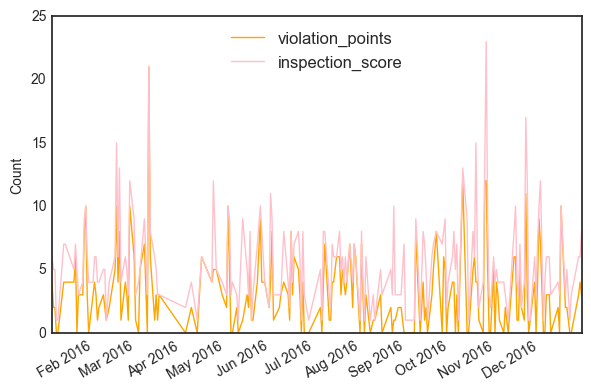

In [44]:
df.groupby('inspection_date')[['violation_points', 'inspection_score']].count().plot(color=['orange', 'pink'])
plt.xlabel('')
plt.ylabel('Count')
plt.tight_layout()

Nothing too alarming here.. violations track with inspections

In [62]:
groupby.head()

,name,inspection_score,violation_points,violations_per_inspection
0,10 Mercer Restaurant,6,5,0.833333
1,100 Lb Clam,1,0,0.000000
2,13 Coins,8,8,1.000000
3,5-Spot,6,6,1.000000
4,7-Eleven Store #14368A,2,0,0.000000


In [63]:
df[df.name == '10 Mercer Restaurant']

,address,city,inspection_closed_business,inspection_date,inspection_result,inspection_score,inspection_type,latitude,longitude,name,violation_description,violation_points,violation_type,zip_code,violation_code
0,10 Mercer St,Seattle,N,2016-10-10,Unsatisfactory,15,Routine Inspection/Field Review,47.625064,-122.356191,10 Mercer Restaurant,Raw meats below and away from ready to eat foo...,5.0,Red,98109,1400
1,10 Mercer St,Seattle,N,2016-10-10,Unsatisfactory,15,Routine Inspection/Field Review,47.625064,-122.356191,10 Mercer Restaurant,Proper cold holding temperatures ( 42 degrees ...,5.0,Red,98109,2120
2,10 Mercer St,Seattle,N,2016-10-10,Unsatisfactory,15,Routine Inspection/Field Review,47.625064,-122.356191,10 Mercer Restaurant,"Warewashing facilities properly installed,...",5.0,Blue,98109,4100
3,10 Mercer St,Seattle,N,2016-07-07,Complete,N/A,Consultation/Education - Field,47.625064,-122.356191,10 Mercer Restaurant,None,NaN,None,98109,None
4,10 Mercer St,Seattle,N,2016-02-24,Unsatisfactory,15,Routine Inspection/Field Review,47.625064,-122.356191,10 Mercer Restaurant,"Toxic substances properly identified,...",10.0,Red,98109,2500
5,10 Mercer St,Seattle,N,2016-02-24,Unsatisfactory,15,Routine Inspection/Field Review,47.625064,-122.356191,10 Mercer Restaurant,"Food-contact surfaces maintained, clean, sanit...",5.0,Blue,98109,4200


In [70]:
df[df.name == '10 Mercer Restaurant'].groupby('inspection_date').count()

,address,city,inspection_closed_business,inspection_result,inspection_score,inspection_type,latitude,longitude,name,violation_description,violation_points,violation_type,zip_code,violation_code
inspection_date,,,,,,,,,,,,,,
2016-02-24,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2016-07-07,1,1,1,1,1,1,1,1,1,0,0,0,1,0
2016-10-10,3,3,3,3,3,3,3,3,3,3,3,3,3,3


In [ ]:
df[df.name == '10 Mercer Restaurant'].groupby('inspection_date')

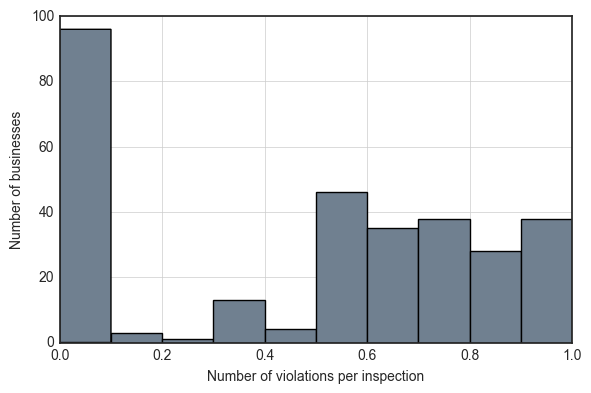

In [61]:
# what is the distribution of the number of violations per inspection per business?
groupby = df.groupby('name')[['inspection_score','violation_points']].count().reset_index()
groupby['violations_per_inspection'] = groupby['violation_points'] / groupby['inspection_score']
groupby['violations_per_inspection'].sort_values(ascending=False).hist(color='slategray')
plt.xlabel('Number of violations per inspection')
plt.ylabel('Number of businesses')
plt.tight_layout()

Most businesses appear to have 0 violations per inspection (yay!!!).

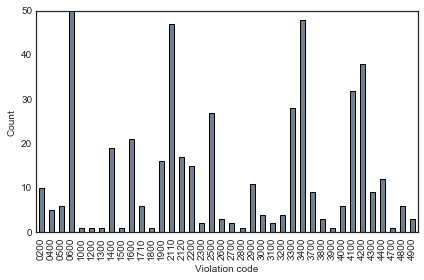

In [23]:
df.groupby('violation_code')['violation_code'].count().plot(kind="bar", color='slategray')
plt.xlabel('Violation code')
plt.ylabel('Count')
plt.tight_layout()

## Maps

In [41]:
# get a single record for each inspection
map_data = df[['name', 'inspection_date', 'inspection_result', 'latitude', 'longitude']].drop_duplicates()
# folium doesn't auto discard null lat/long (this is an empty issue, see https://github.com/python-visualization/folium/issues/461)
map_data = map_data[(map_data.latitude.isnull() == False) & (map_data.longitude.isnull() == False)]

In [42]:
# this outputs to file
restaurant_map = folium.Map(location=[map_data['latitude'].mean(), map_data['longitude'].mean()], zoom_start=10)
marker_cluster = folium.MarkerCluster().add_to(restaurant_map)
for i, row in map_data.iterrows():
    folium.Marker([row['latitude'], row['longitude']], popup='{0}: {1} ({2})'.format(row['name'], row['inspection_result'], row['inspection_date'].date())
).add_to(marker_cluster)
restaurant_map.save('maps/restaurants.html')

Here's a **screenshot** of the resulting map. The map can be viewed interactively by downloading the maps/restaurants.html file locally.

![map](maps/map_screenshot.png)

In [53]:
test = df.head(5).copy()

In [62]:
test.iloc[0]

address                                         10 Mercer St
city                                                 Seattle
inspection_closed_business                                 N
inspection_date                          2016-07-07 00:00:00
inspection_result                                   Complete
inspection_score                                         N/A
inspection_type               Consultation/Education - Field
latitude                                             47.6251
longitude                                           -122.356
name                                    10 Mercer Restaurant
violation_description                                   None
violation_points                                         NaN
violation_type                                          None
zip_code                                               98109
violation_code                                          None
Name: 0, dtype: object

In [66]:
params = ['attr1', 'attr2', 'attr3']
for p in params:
    setattr(test, p, 5)

In [67]:
test.columns

Index(['address', 'city', 'inspection_closed_business', 'inspection_date',
       'inspection_result', 'inspection_score', 'inspection_type', 'latitude',
       'longitude', 'name', 'violation_description', 'violation_points',
       'violation_type', 'zip_code', 'violation_code'],
      dtype='object')